CC(=O)Oc1cccc(C(C)C(=O)O)c1


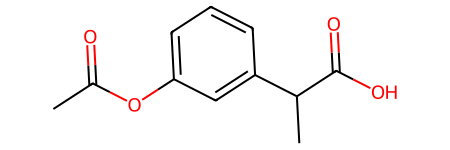

In [3]:
from rdkit import Chem

mol = Chem.MolFromSmiles('CC(=O)OC1=CC=CC(=C1)C(C)C(=O)O')
print(Chem.MolToSmiles(mol))
mol

In [27]:
import requests
from functools import cache

from urllib.request import urlopen
from urllib.parse import quote
import timeit 

from py2opsin import py2opsin
import warnings

@cache
def iupac_to_smiles1(iupac_name):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, module='py2opsin')
        
        if type(iupac_name) != str:
            return None
        
        # replace all whitespace with dashes, double dashes with single dashes
        iupac_name = iupac_name.replace(' ', '-').replace('\n', '-').replace('\t', '-') 
        iupac_name = iupac_name.strip('-')
        while '--' in iupac_name:
            iupac_name = iupac_name.replace('--', '-')

        # corner case 1: remove stereochemistry
        iupac_name = iupac_name.lstrip('(R/S)-').lstrip('(S/R)-')

        smiles_string = py2opsin(
            chemical_name=iupac_name,
            output_format="SMILES"
        )

        if not smiles_string:
            return None
        return smiles_string

@cache
def iupac_to_smiles2(iupac_name):
    '''
    This one is significantly better
    '''
    if type(iupac_name) != str:
        return None
    iupac_name = iupac_name.replace(' ', '-')
    iupac_name = iupac_name.strip('-')
    iupac_name = iupac_name.lstrip('(R/S)-').lstrip('(S/R)-')
    url = f"https://opsin.ch.cam.ac.uk/opsin/{iupac_name}.smi"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text.strip()
    return None

iupac_name = '''2-(4-(((2-Bromo-2-methylpropanoyl)thio)methyl)benzamido)
ethan-1-aminium chloride'''
smiles = iupac_to_smiles1(iupac_name)
smiles

'[Cl-].BrC(C(=O)SCC1=CC=C(C(=O)NCC[NH3+])C=C1)(C)C'

In [28]:
import pandas as pd

data = pd.read_csv(r'../SURP-database-reformatted - Flexizymes ready for database.csv', skiprows=1)

SMILES = []
for iupac in data['Monomer Names (required)']:
    method1, method2 = iupac_to_smiles1(iupac), iupac_to_smiles2(iupac)
    if method1 or method2: 
        SMILES.append({
            'IUPAC': iupac,
            'SMILES1': method1,
            'SMILES2': method2
        })
        

In [22]:
# put into new csv
SMILES_df = pd.DataFrame(SMILES)
SMILES_df.to_csv('IUPAC_TO_SMILES.csv')